In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=d43f6d7f3e6c5f860e89e6798d0b57d85e50c1e2577a870b8697db8b64536a78
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
# Create a Spark session
spark = SparkSession.builder.appName("ChildLifeExpectancyAnalysis").getOrCreate()
#loading dataset
data = spark.read.csv("/content/sample_data/Life Expectancy Data.csv", header=True, inferSchema=True)
# Display all attributes in the dataset
data.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- LifeExpectancy: double (nullable = true)
 |-- AdultMortality: integer (nullable = true)
 |-- infantdeaths: integer (nullable = true)
 |-- Alcohol: double (nullable = true)
 |-- %expenditure: double (nullable = true)
 |-- Measles: integer (nullable = true)
 |--  BMI : double (nullable = true)
 |-- underfivedeaths: integer (nullable = true)
 |-- Polio: integer (nullable = true)
 |-- Totalexpenditure: double (nullable = true)
 |-- Diphtheria: integer (nullable = true)
 |-- HIVAIDS: double (nullable = true)
 |-- thinness: double (nullable = true)
 |--  fthinness: double (nullable = true)



In [ ]:
# describing target attribute
data.select('LifeExpectancy').describe().show()

+-------+-----------------+
|summary|   LifeExpectancy|
+-------+-----------------+
|  count|             2675|
|   mean|69.27891588785033|
| stddev|9.543372448321797|
|    min|             36.3|
|    max|             89.0|
+-------+-----------------+



In [ ]:
import pandas as pd
pd.DataFrame(data.take(5), columns=data.columns)

,Country,Year,Status,LifeExpectancy,AdultMortality,infantdeaths,Alcohol,%expenditure,Measles,BMI,underfivedeaths,Polio,Totalexpenditure,Diphtheria,HIVAIDS,thinness,fthinness
0,Kiribati,2004,Developing,64.8,214,0,0.48,10.624274,0,71.4,0,61,1.39,62,0.1,0.2,0.2
1,Kiribati,2003,Developing,64.7,215,0,0.50,1.765413,0,7.6,0,79,9.98,7,0.1,0.2,0.2
2,Kiribati,2001,Developing,64.3,219,0,0.60,59.971858,0,68.8,0,88,9.00,85,0.1,0.2,0.2
3,Kiribati,2000,Developing,64.1,222,0,0.46,11.075433,0,67.9,0,9,8.12,9,0.1,0.2,0.2
4,Kiribati,2002,Developing,64.6,217,0,0.49,70.755722,0,69.7,0,96,9.10,77,0.1,0.2,0.2


In [ ]:
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index", handleInvalid="keep") for column in [ "Status"]]
encoder = [OneHotEncoder(inputCols=[column+"_index"], outputCols=[column+"_encoded"]) for column in [ "Status"]]
indexers_and_encoders = indexers + encoder
indexer_model = [indexer.fit(data) for indexer in indexers]
encoded_data = data
for i in range(len(indexers)):
    encoded_data = indexer_model[i].transform(encoded_data)
print(encoded_data)


DataFrame[Country: string, Year: int, Status: string, LifeExpectancy: double, AdultMortality: int, infantdeaths: int, Alcohol: double, %expenditure: double, Measles: int,  BMI : double, underfivedeaths: int, Polio: int, Totalexpenditure: double, Diphtheria: int, HIVAIDS: double, thinness: double,  fthinness: double, Status_index: double]


In [ ]:
print(indexers)
print(encoder)
print(indexers_and_encoders)
print(indexer_model)
print(encoded_data)
encoded_data.show()

[StringIndexer_a550c51daf50]
[OneHotEncoder_286048ed6d44]
[StringIndexer_a550c51daf50, OneHotEncoder_286048ed6d44]
[StringIndexerModel: uid=StringIndexer_a550c51daf50, handleInvalid=keep]
DataFrame[Country: string, Year: int, Status: string, LifeExpectancy: double, AdultMortality: int, infantdeaths: int, Alcohol: double, %expenditure: double, Measles: int,  BMI : double, underfivedeaths: int, Polio: int, Totalexpenditure: double, Diphtheria: int, HIVAIDS: double, thinness: double,  fthinness: double, Status_index: double]
+--------------------+----+----------+--------------+--------------+------------+-------+------------+-------+-----+---------------+-----+----------------+----------+-------+--------+----------+------------+
|             Country|Year|    Status|LifeExpectancy|AdultMortality|infantdeaths|Alcohol|%expenditure|Measles| BMI |underfivedeaths|Polio|Totalexpenditure|Diphtheria|HIVAIDS|thinness| fthinness|Status_index|
+--------------------+----+----------+--------------+---

In [ ]:
# Assemble features
feature_columns = encoded_data.columns
print(feature_columns)
feature_columns.remove("LifeExpectancy")
feature_columns.remove("Country")
feature_columns.remove("Alcohol")
feature_columns.remove("Status")
feature_columns.remove("%expenditure")
feature_columns.remove("Totalexpenditure")
feature_columns.remove("Status_index")
feature_columns.remove(" BMI ")
feature_columns.remove(" fthinness")
print(feature_columns)
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
print(assembler)
assembled_data = assembler.transform(encoded_data)
print(assembled_data)
assembled_data.show()

['Country', 'Year', 'Status', 'LifeExpectancy', 'AdultMortality', 'infantdeaths', 'Alcohol', '%expenditure', 'Measles', ' BMI ', 'underfivedeaths', 'Polio', 'Totalexpenditure', 'Diphtheria', 'HIVAIDS', 'thinness', ' fthinness', 'Status_index']
['Year', 'AdultMortality', 'infantdeaths', 'Measles', 'underfivedeaths', 'Polio', 'Diphtheria', 'HIVAIDS', 'thinness']
VectorAssembler_2c5fbc6f4e60
DataFrame[Country: string, Year: int, Status: string, LifeExpectancy: double, AdultMortality: int, infantdeaths: int, Alcohol: double, %expenditure: double, Measles: int,  BMI : double, underfivedeaths: int, Polio: int, Totalexpenditure: double, Diphtheria: int, HIVAIDS: double, thinness: double,  fthinness: double, Status_index: double, features: vector]
+--------------------+----+----------+--------------+--------------+------------+-------+------------+-------+-----+---------------+-----+----------------+----------+-------+--------+----------+------------+--------------------+
|             Country

In [ ]:
assembled_data.show(5)
display(feature_columns)

+--------+----+----------+--------------+--------------+------------+-------+------------+-------+-----+---------------+-----+----------------+----------+-------+--------+----------+------------+--------------------+
| Country|Year|    Status|LifeExpectancy|AdultMortality|infantdeaths|Alcohol|%expenditure|Measles| BMI |underfivedeaths|Polio|Totalexpenditure|Diphtheria|HIVAIDS|thinness| fthinness|Status_index|            features|
+--------+----+----------+--------------+--------------+------------+-------+------------+-------+-----+---------------+-----+----------------+----------+-------+--------+----------+------------+--------------------+
|Kiribati|2004|Developing|          64.8|           214|           0|   0.48|  10.6242741|      0| 71.4|              0|   61|            1.39|        62|    0.1|     0.2|       0.2|         0.0|[2004.0,214.0,0.0...|
|Kiribati|2003|Developing|          64.7|           215|           0|    0.5|  1.76541345|      0|  7.6|              0|   79|      

['Year',
 'AdultMortality',
 'infantdeaths',
 'Measles',
 'underfivedeaths',
 'Polio',
 'Diphtheria',
 'HIVAIDS',
 'thinness']

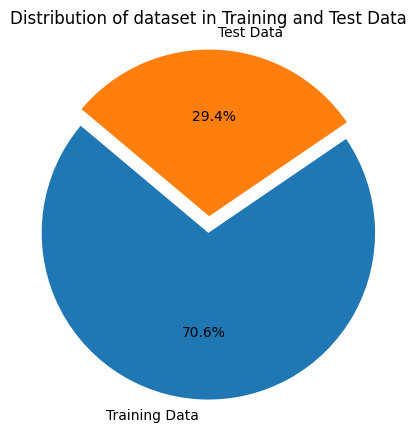

In [ ]:
train_data, test_data = assembled_data.randomSplit([0.7, 0.3], seed=125)
# Hypothetical data for the pie chart
train_infant_deaths = train_data.select("LifeExpectancy").rdd.flatMap(lambda x: x).collect()
test_infant_deaths = test_data.select("LifeExpectancy").rdd.flatMap(lambda x: x).collect()
labels = ['Training Data', 'Test Data']
sizes = [sum(train_infant_deaths), sum(test_infant_deaths)]
explode = (0.1, 0)  # Explode the first slice (Training Data)
# Plotting the pie chart
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Distribution of dataset in Training and Test Data')
plt.show()

In [ ]:
# creating LR model
lr = LinearRegression(featuresCol="features", labelCol="LifeExpectancy")
lr_model = lr.fit(train_data)
#predection
lr_predictions = lr_model.transform(test_data)
#Predection results
lr_results = lr_predictions.select( "LifeExpectancy", "prediction")
lr_results.show(5)

+--------------+------------------+
|LifeExpectancy|        prediction|
+--------------+------------------+
|          56.2| 61.07908107488936|
|          57.3|55.722106816548376|
|          57.3|55.810122416927356|
|          57.5|56.628451108144986|
|          58.1| 57.20295334634639|
+--------------+------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="LifeExpectancy", predictionCol="prediction")
rmse1 = evaluator.evaluate(lr_results)
print("Root-mean-square error = " + str(rmse1))
evaluator = RegressionEvaluator(metricName="r2", labelCol="LifeExpectancy", predictionCol="prediction")
r21 = evaluator.evaluate(lr_results)
print("R2 = " + str(r21))
#evaluator = RegressionEvaluator(metricName="mae", labelCol="LifeExpectancy", predictionCol="prediction")
#r23 = evaluator.evaluate(lr_results)
#print("mae = " + str(r23))


Root-mean-square error = 5.166257472688637
R2 = 0.708387812342352


In [ ]:
evaluator = RegressionEvaluator(metricName="r2", labelCol="LifeExpectancy", predictionCol="prediction")
r21 = evaluator.evaluate(lr_results)
print("Accuracy of Linear Regression = " + str(r21))

Accuracy of Linear Regression = 0.708387812342352


In [ ]:
# creating gbt model
gbt = GBTRegressor(featuresCol="features", labelCol="LifeExpectancy", maxIter=10, maxBins=200)
gbt_model = gbt.fit(train_data)
# predection
gbt_predictions = gbt_model.transform(test_data)
# predection results
gbt_results = gbt_predictions.select( "LifeExpectancy", "prediction")
gbt_results.show(5)

+--------------+------------------+
|LifeExpectancy|        prediction|
+--------------+------------------+
|          56.2| 64.45729041342882|
|          57.3|54.699209254910805|
|          57.3|  54.7746524007837|
|          57.5|  54.7746524007837|
|          58.1|  54.7746524007837|
+--------------+------------------+
only showing top 5 rows



In [ ]:
#GBT
evaluator = RegressionEvaluator(labelCol="LifeExpectancy", predictionCol="prediction", metricName="rmse")
rmse2 = evaluator.evaluate(gbt_results)
print("Root-mean-square error = " + str(rmse2))

evaluator = RegressionEvaluator(labelCol="LifeExpectancy", predictionCol="prediction", metricName="r2")
r22 = evaluator.evaluate(gbt_results)
print("R-squared = " + str(r22))


Root-mean-square error = 2.893278549292861
R-squared = 0.9085393944629028


In [ ]:
evaluator = RegressionEvaluator(labelCol="LifeExpectancy", predictionCol="prediction", metricName="r2")
r22 = evaluator.evaluate(gbt_results)
print("Accuracy of GBT= " + str(r22))


Accuracy of GBT= 0.9085393944629028


In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'LifeExpectancy', maxBins=180)
dt_model = dt.fit(train_data)
dt_predictions = dt_model.transform(test_data)
dt_results=dt_predictions.select("LifeExpectancy","prediction")
dt_results.show(5)


+--------------+-----------------+
|LifeExpectancy|       prediction|
+--------------+-----------------+
|          56.2|68.60000000000001|
|          57.3|54.86250000000007|
|          57.3|54.86250000000007|
|          57.5|54.86250000000007|
|          58.1|54.86250000000007|
+--------------+-----------------+
only showing top 5 rows



In [ ]:
evaluator = RegressionEvaluator(labelCol="LifeExpectancy", predictionCol="prediction", metricName="rmse")
rmse3 = evaluator.evaluate(dt_predictions)
print("Root-mean-square error = " + str(rmse3))

evaluator = RegressionEvaluator(labelCol="LifeExpectancy", predictionCol="prediction", metricName="r2")
r23 = evaluator.evaluate(dt_predictions)
print("R-squared = " + str(r23))


Root-mean-square error = 3.399168023788089
R-squared = 0.8737594600723395


In [ ]:
evaluator = RegressionEvaluator(labelCol="LifeExpectancy", predictionCol="prediction", metricName="r2")
r23 = evaluator.evaluate(dt_predictions)
print("Accuracy of Decision Tree Regression= " + str(r23))

Accuracy of Decision Tree Regression= 0.8737594600723395


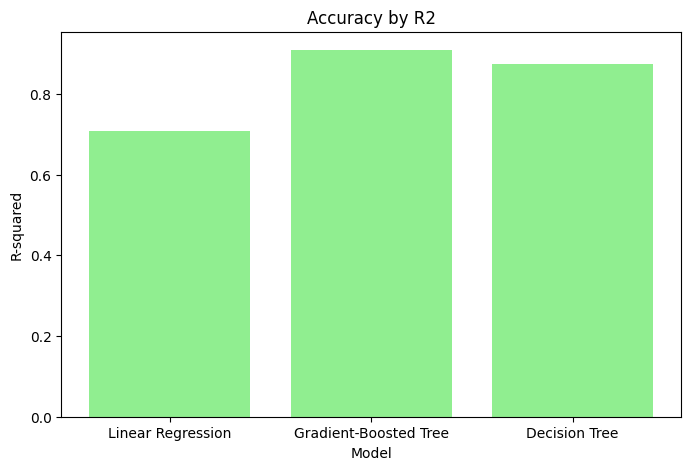

In [ ]:
import matplotlib.pyplot as plt

r2_values = [r21,r22,r23]
model_names = ["Linear Regression", "Gradient-Boosted Tree", "Decision Tree"]

plt.figure(figsize=(8, 5))
plt.bar(model_names, r2_values, color='lightgreen')
plt.xlabel("Model")
plt.ylabel("R-squared")
plt.title("Accuracy by R2")
plt.show()


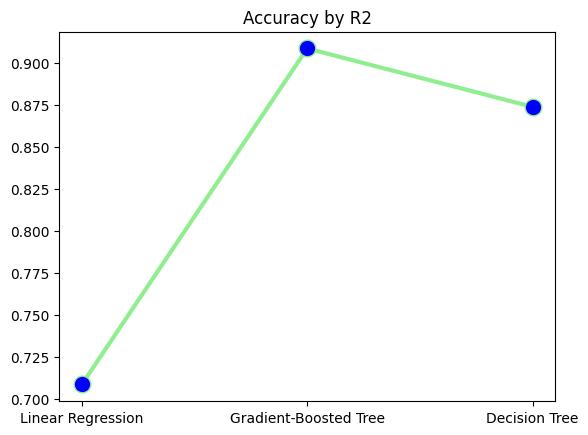

In [ ]:
import matplotlib.pyplot as plt
plt.plot(model_names, r2_values, color='lightgreen',  linewidth=3, marker='o', markerfacecolor='blue', markersize=12)
plt.title("Accuracy by R2")
plt.show()


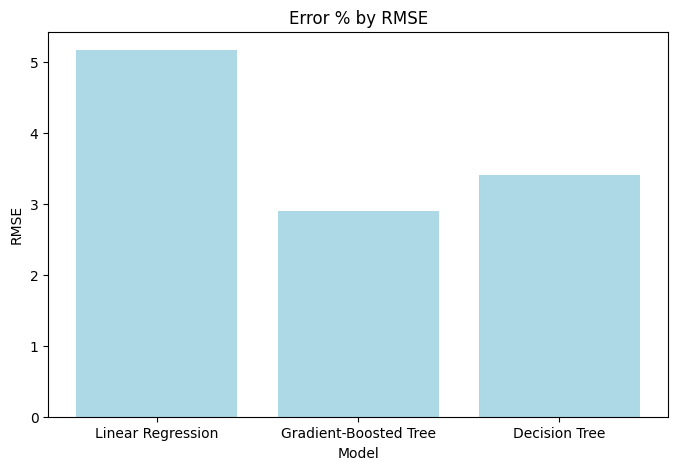

In [ ]:
rmse_values = [rmse1,rmse2,rmse3]
model_names = ["Linear Regression", "Gradient-Boosted Tree", "Decision Tree"]

plt.figure(figsize=(8,5))
plt.bar(model_names, rmse_values, color='lightblue')
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.title("Error % by RMSE")
plt.show()


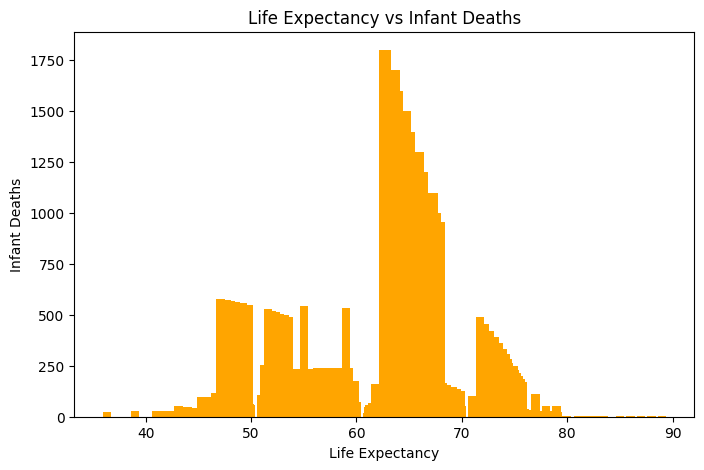

In [ ]:
life_expectancy = data.select("LifeExpectancy").rdd.flatMap(lambda x: x).collect()
infant_deaths = data.select("InfantDeaths").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(8, 5))
plt.bar(life_expectancy, infant_deaths, color='orange')
plt.xlabel("Life Expectancy")
plt.ylabel("Infant Deaths")
plt.title("Life Expectancy vs Infant Deaths")
plt.show()


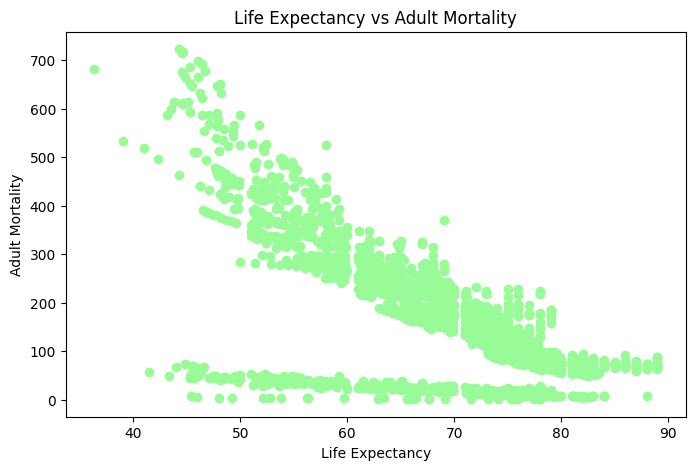

In [ ]:
import matplotlib.pyplot as plt
adult_mortality = data.select("AdultMortality").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(8, 5))
plt.scatter(life_expectancy, adult_mortality, color='palegreen')
plt.xlabel("Life Expectancy")
plt.ylabel("Adult Mortality")
plt.title("Life Expectancy vs Adult Mortality")
plt.show()


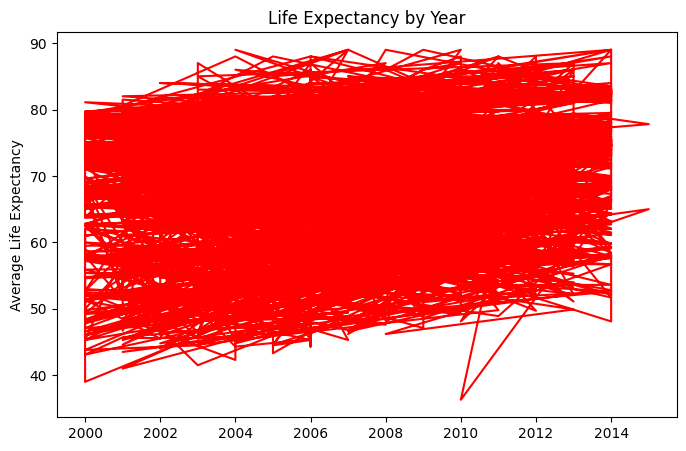

In [ ]:
import matplotlib.pyplot as plt
Year = data.select("Year").rdd.flatMap(lambda x: x).collect()
le = data.select("LifeExpectancy").rdd.flatMap(lambda x: x).collect()
plt.figure(figsize=(8,5))
plt.plot(Year,le,color='red',label='LifeExpectancy')
plt.ylabel("Average Life Expectancy")
plt.title("Life Expectancy by Year")
plt.show()


In [ ]:
actual_vs_predicted = gbt_predictions.select( "LifeExpectancy", "prediction")
import pyspark.sql.functions as F
similar_predictions = actual_vs_predicted.orderBy(F.abs(actual_vs_predicted["LifeExpectancy"] - actual_vs_predicted["prediction"]), ascending=True).limit(5)
similar_predictions.show()
best_prediction = similar_predictions.orderBy("LifeExpectancy", ascending=False).first()
print("Most accurate prediction:")
print("Actual value:", best_prediction["LifeExpectancy"])
print("Predicted value:", best_prediction["prediction"])

+--------------+-----------------+
|LifeExpectancy|       prediction|
+--------------+-----------------+
|          77.8| 77.7935057081647|
|          52.1|52.08832642663101|
|          82.0|81.98123971793564|
|          66.8|66.83128199316425|
|          82.6|82.63251068236937|
+--------------+-----------------+

Most accurate prediction:
Actual value: 82.6
Predicted value: 82.63251068236937


In [ ]:
actual_vs_predicted = dt_predictions.select( "LifeExpectancy", "prediction")
import pyspark.sql.functions as F
similar_predictions = actual_vs_predicted.orderBy(F.abs(actual_vs_predicted["LifeExpectancy"] - actual_vs_predicted["prediction"]), ascending=True).limit(5)
similar_predictions.show()
best_prediction = similar_predictions.orderBy("LifeExpectancy", ascending=False).first()
print("Most accurate prediction:")
print("Actual value:", best_prediction["LifeExpectancy"])
print("Predicted value:", best_prediction["prediction"])

+--------------+------------------+
|LifeExpectancy|        prediction|
+--------------+------------------+
|          52.2|52.203030303030296|
|          72.0| 72.00476190476192|
|          72.0| 72.00476190476192|
|          64.0| 64.00625000000002|
|          74.2|  74.2140211640212|
+--------------+------------------+

Most accurate prediction:
Actual value: 74.2
Predicted value: 74.2140211640212


In [ ]:
actual_vs_predicted = lr_predictions.select( "LifeExpectancy", "prediction")
import pyspark.sql.functions as F
similar_predictions = actual_vs_predicted.orderBy(F.abs(actual_vs_predicted["LifeExpectancy"] - actual_vs_predicted["prediction"]), ascending=True).limit(5)
similar_predictions.show()
best_prediction = similar_predictions.orderBy("LifeExpectancy", ascending=False).first()
print("Most accurate prediction:")
print("Actual value:", best_prediction["LifeExpectancy"])
print("Predicted value:", best_prediction["prediction"])

+--------------+-----------------+
|LifeExpectancy|       prediction|
+--------------+-----------------+
|          74.1|74.09537110704832|
|          72.8|72.79320680341053|
|          73.5|73.48919032767981|
|          71.0|70.98700649725149|
|          57.3|57.28422029386658|
+--------------+-----------------+

Most accurate prediction:
Actual value: 74.1
Predicted value: 74.09537110704832


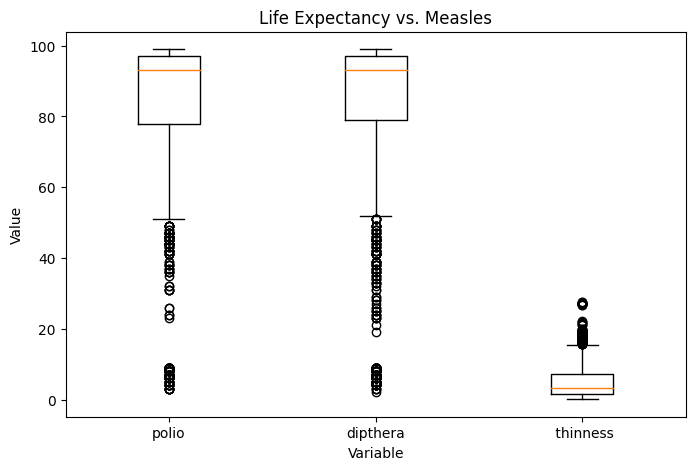

In [ ]:
import matplotlib.pyplot as plt
polio = data.select("Polio").rdd.flatMap(lambda x: x).collect()
dip = data.select("Diphtheria").rdd.flatMap(lambda x: x).collect()
thinnss = data.select("thinness").rdd.flatMap(lambda x: x).collect()
plt.figure(figsize=(8, 5))
plt.boxplot([polio,dip,thinnss], labels=["polio", "dipthera"," thinness"])
plt.title("Life Expectancy vs. Measles")
plt.xlabel("Variable")
plt.ylabel("Value")
plt.show()


In [ ]:
input_year=input("Enter the age: ")
input_am=input("Enter the adult_mortality: ")
input_id=input("Enter the infant_deaths: ")
input_m=input("Enter the measles: ")
input_ufd=input("Enter the under five deaths: ")
input_polio=input("Enter the polio: ")
input_dip=input("Enter the diphteria: ")
input_aids=input("Enter the aids: ")
input_thin=input("Enter the thinness: ")
Year=int(input_year)
AdultMortality=int(input_am)
infantdeaths=int(input_id)
Measles=int(input_m)
underfivedeaths =int(input_ufd)
Polio=int(input_polio)
Diphtheria =int(input_dip)
HIVAIDS=float(input_aids)
thinness=float(input_thin)



new_data_df = spark.createDataFrame(new_data,["Year","AdultMortality","infantdeaths","Measles","underfivedeaths","Polio","Diphtheria","HIVAIDS","thinness"])
new_data_df=assembler.transform(new_data_df)
new_prediction=dt_model.transform(new_data_df)

prediction=new_prediction.select("prediction").collect()[0]["prediction"]
print("Life expectancy: ",prediction)

Enter the age: 2004
Enter the adult_mortality: 323
Enter the infant_deaths: 49
Enter the measles: 77
Enter the under five deaths: 91
Enter the polio: 83
Enter the diphteria: 79
Enter the aids: 2.5
Enter the thinness: 1.5
Life expectancy:  54.3505376344086
